In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
import optuna
import os
import math

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [3]:
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 20
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
m=len(train_dataset)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset.transform=transform

In [3]:
class Pgelu1(nn.Module): #带参数的gelu激活函数
    def __init__(self, trial):
        super().__init__()
        self.sigma = trial.suggest_float('sigma1',0,10) #可学习参数 sigma

    def forward(self, input):
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2

In [4]:
class Pgelu2(nn.Module): #带参数的gelu激活函数
    def __init__(self, trial):
        super().__init__()
        self.sigma = trial.suggest_float('sigma2',0,10) #可学习参数 sigma

    def forward(self, input):
    #    sigma = trial.suggest_float('sigma2',0,10)
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2

In [5]:
class Pgelu3(nn.Module): #带参数的gelu激活函数
    def __init__(self, trial):
        super().__init__()
        self.sigma = trial.suggest_float('sigma3',0,10) #可学习参数 sigma

    def forward(self, input):
    #    sigma = trial.suggest_float('sigma2',0,10)
        temp2=input/2*(1+torch.erf(input/math.sqrt(2)/self.sigma))
        return temp2

In [4]:
# 自定义激活函数的网络

class ConvNet(nn.Module):
    def __init__(self, trial):
        # We optimize dropout rate in a convolutional neural network.
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.custom1 = Pgelu1(trial)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.custom2 = Pgelu2(trial)
        
        dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5)
        self.drop1=nn.Dropout2d(p=dropout_rate)   
        
        fc2_input_dim = trial.suggest_int("fc2_input_dim", 32, 128)
        self.fc1 = nn.Linear(32 * 7 * 7, fc2_input_dim)
        self.custom3 = Pgelu3(trial)
        
        dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.3)
        self.drop2=nn.Dropout2d(p=dropout_rate2)

        self.fc2 = nn.Linear(fc2_input_dim, 10)

    def forward(self, x):
        x = self.custom1(F.max_pool2d(self.conv1(x),kernel_size = 2))
        x = self.custom2(F.max_pool2d(self.conv2(x),kernel_size = 2))
        x = self.drop1(x)

        x = x.view(x.size(0),-1)

        x = self.custom3(self.fc1(x))
        x = self.drop2(x)

        x = self.fc2(x)

        return x

In [7]:
def get_mnist(train_dataset,batch_size):

    train_data, val_data = random_split(train_dataset, [int(m*0.8), int(m*0.2)])
    # The dataloaders handle shuffling, batching, etc...
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    return train_loader, valid_loader

In [5]:
def objective(trial):

    # Generate the model.
    model = ConvNet(trial).to(DEVICE)

    # Generate the optimizers.

   #try Adam, AdaDelta adn Adagrad
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    batch_size=trial.suggest_int("batch_size", 64, 256,step=64)

    criterion=nn.CrossEntropyLoss()

    # Get the MNIST imagesset.
    train_loader, valid_loader = get_mnist(train_dataset,batch_size)
    
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
       
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Limiting training images for faster epochs.
            #if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #    break

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                # Limiting validation images.
               # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #    break
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                output = model(images)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)

        trial.report(accuracy, epoch)

        # 根据intermediate value进行剪枝，加快贝叶斯寻优过程
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
     

[I 2023-09-19 08:10:21,440] A new study created in memory with name: no-name-1d4a3cf1-09a4-45a0-9e5d-ebce2d361816
D:\DeepLearning\Anaconda\envs\pytorch\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
[I 2023-09-19 08:19:09,433] Trial 0 finished with value: 0.97125 and parameters: {'sigma1': 3.4465093503228594, 'sigma2': 9.987359987226133, 'dropout_rate': 0.322006687691048, 'fc2_input_dim': 94, 'sigma3': 4.994944520059606, 'dropout_rate2': 0.07147346249469179, 'optimizer': 'SGD', 'lr': 0.023983097489532805, 'batch_size': 256}. Best is trial 0 with value: 0.97125.
[I 2023-09-19 08:28:29,786] 

Accuracy: 0.991
Best hyperparameters: {'sigma1': 9.993133575525853, 'sigma2': 3.587017226394411, 'dropout_rate': 0.14307513160021024, 'fc2_input_dim': 72, 'sigma3': 9.077326527865678, 'dropout_rate2': 0.2612457271322456, 'optimizer': 'Adam', 'lr': 0.0015814285749924351, 'batch_size': 128}


In [75]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
     

[I 2023-09-13 23:05:28,391] A new study created in memory with name: no-name-3504215b-ce9f-4f34-9b1a-79d365a69776
[I 2023-09-13 23:07:58,205] Trial 0 finished with value: 0.9540833333333333 and parameters: {'sigma1': 6.296820749532078, 'sigma2': 1.8052845992745048, 'dropout_rate': 0.1996761255413267, 'fc2_input_dim': 119, 'sigma3': 0.02460578026612703, 'dropout_rate2': 0.02269242809037646, 'optimizer': 'Adadelta', 'lr': 0.006355721423767675, 'batch_size': 64}. Best is trial 0 with value: 0.9540833333333333.
[I 2023-09-13 23:09:37,971] Trial 1 finished with value: 0.7271666666666666 and parameters: {'sigma1': 2.6621677425066013, 'sigma2': 7.7136613400964755, 'dropout_rate': 0.2713708591947654, 'fc2_input_dim': 103, 'sigma3': 4.5884432560359425, 'dropout_rate2': 0.009789388581304315, 'optimizer': 'Adagrad', 'lr': 7.651156693112524e-05, 'batch_size': 192}. Best is trial 0 with value: 0.9540833333333333.
[I 2023-09-13 23:11:31,488] Trial 2 finished with value: 0.33341666666666664 and param

Accuracy: 0.9925833333333334
Best hyperparameters: {'sigma1': 4.061858492681086, 'sigma2': 1.4768172994467532, 'dropout_rate': 0.422354026716094, 'fc2_input_dim': 75, 'sigma3': 2.575420180942363, 'dropout_rate2': 0.18387295345267168, 'optimizer': 'Adam', 'lr': 0.0020132916678798317, 'batch_size': 192}


In [76]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df.tail(10)

,value,params_batch_size,params_dropout_rate,params_dropout_rate2,params_fc2_input_dim,params_lr,params_optimizer,params_sigma1,params_sigma2,params_sigma3
40,0.981083,256,0.290391,0.217032,65,0.010822,Adam,4.802877,0.305460,3.901991
41,0.967833,192,0.415562,0.228002,70,0.001388,Adam,2.880998,1.573590,1.913176
42,0.984500,192,0.441219,0.256914,57,0.002014,Adam,2.484625,1.050854,1.234726
43,0.958583,192,0.403013,0.178145,70,0.000804,Adam,4.033913,2.199268,1.991659
44,0.990750,192,0.426545,0.233366,50,0.002698,Adam,1.661326,2.948687,0.633459
45,0.979583,128,0.361286,0.203166,83,0.004397,Adam,2.650209,2.536963,2.819408
46,0.972000,192,0.461224,0.192020,65,0.001998,Adam,3.386569,0.623823,1.579564
47,0.098167,192,0.388268,0.220152,77,0.000332,Adadelta,2.387470,1.951725,0.086743
48,0.969000,64,0.476749,0.145954,61,0.000675,Adam,1.671444,1.174728,2.190873
49,0.990417,128,0.347291,0.162384,97,0.001768,Adam,3.186891,1.715207,4.387517


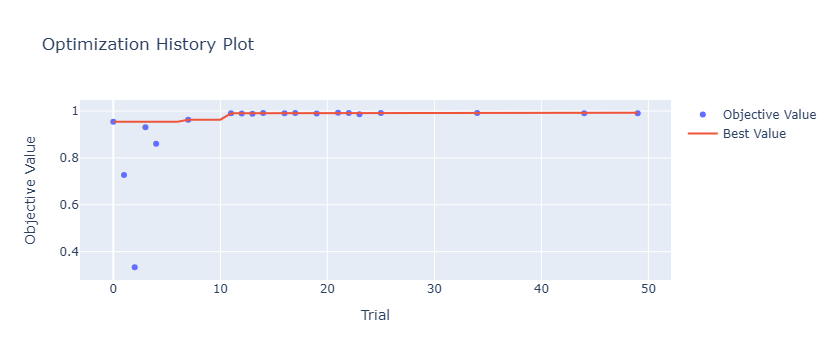

In [77]:
optuna.visualization.plot_optimization_history(study)

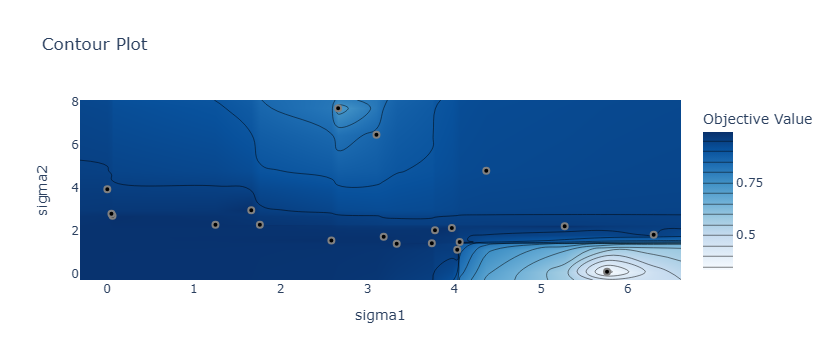

In [78]:
optuna.visualization.plot_contour(study, params=['sigma1', 'sigma2'])

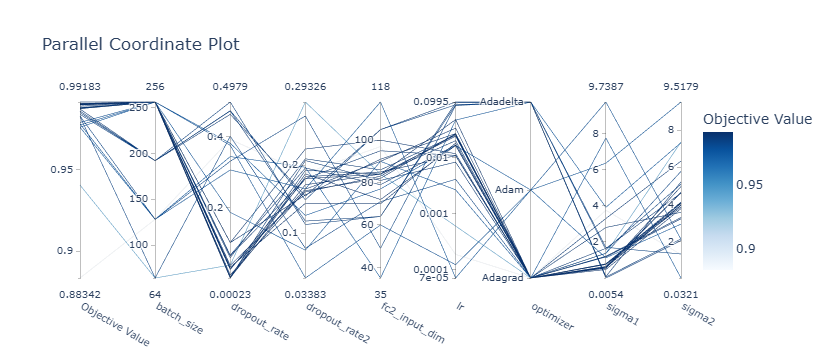

In [70]:
optuna.visualization.plot_parallel_coordinate(study)

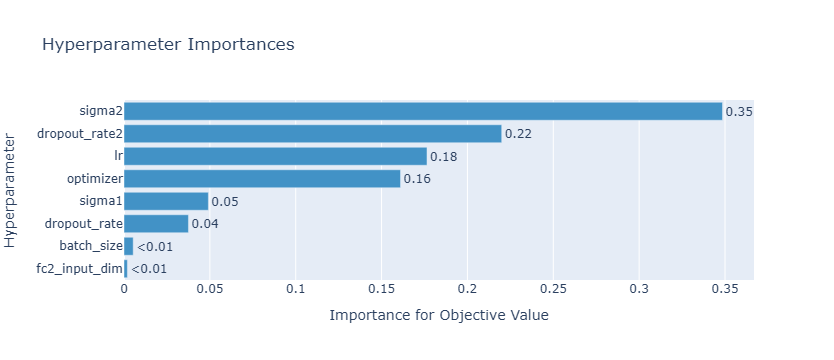

In [64]:
optuna.visualization.plot_param_importances(study)

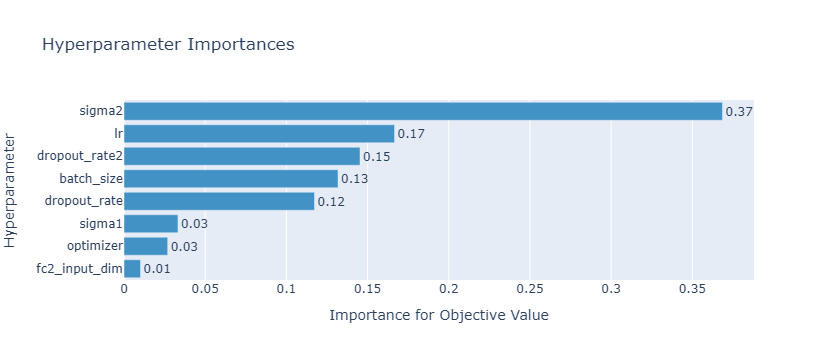

In [71]:
optuna.visualization.plot_param_importances(study)

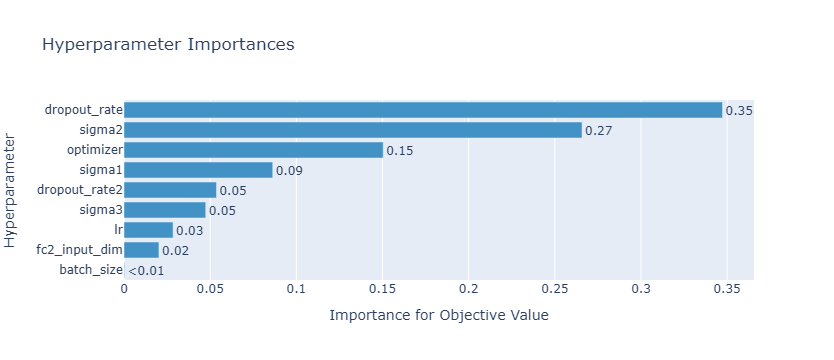

In [79]:
optuna.visualization.plot_param_importances(study)